In [6]:
import cv2
import numpy as np
import sklearn
import os
from glob import glob
import csv
import pickle
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence
import random
from random import shuffle


In [7]:
w, h, c = 320, 160, 3

# warp transform so far-away curbs show better
def get_M(reverse=False):
    src = np.float32( [[0, h], [w / 2 - 80, 60], [w / 2 + 80, 60], [w, h]])
    dst = np.float32( [[0, h], [0, 0], [w, 0], [w, h]])
    if reverse:
        return cv2.getPerspectiveTransform(dst, src)
    else:
        return cv2.getPerspectiveTransform(src, dst)

M = get_M()
def warp_perspective(img, reverse=False):
    return cv2.warpPerspective(img, M, (w, h))
    
samples = []
for csv_file in glob("/home/zhenyaf/data/nd/*/driving_log.csv"):
    with open(csv_file) as f:
        reader = csv.reader(f);
        print(csv_file)
        for line in reader:
            samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print(len(train_samples), len(validation_samples))

def random_flip(image, measurement):
    if np.random.choice((True, False)):
        image = np.fliplr(image)
        measurement = -measurement
    return image, measurement

class generator(Sequence):
    def __init__(self, samples, batch_size=32):
        self.samples = samples
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.samples) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        angles = []
        for batch_sample in batch_samples:
            name = batch_sample[0].replace("/Users/zhenya/htmp/data", "/home/zhenyaf/data/nd")
            center_image = warp_perspective(plt.imread(name))
            #center_image = plt.imread(name)
            center_image, center_angle = random_flip(center_image, float(batch_sample[3]))
            images.append(center_image)
            angles.append(center_angle)

        return np.array(images), np.array(angles)
    
# compile and train the model using the generator function
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)


/home/zhenyaf/data/nd/recov1/driving_log.csv
/home/zhenyaf/data/nd/4/driving_log.csv
/home/zhenyaf/data/nd/2/driving_log.csv
/home/zhenyaf/data/nd/1/driving_log.csv
/home/zhenyaf/data/nd/3/driving_log.csv
27443 6861


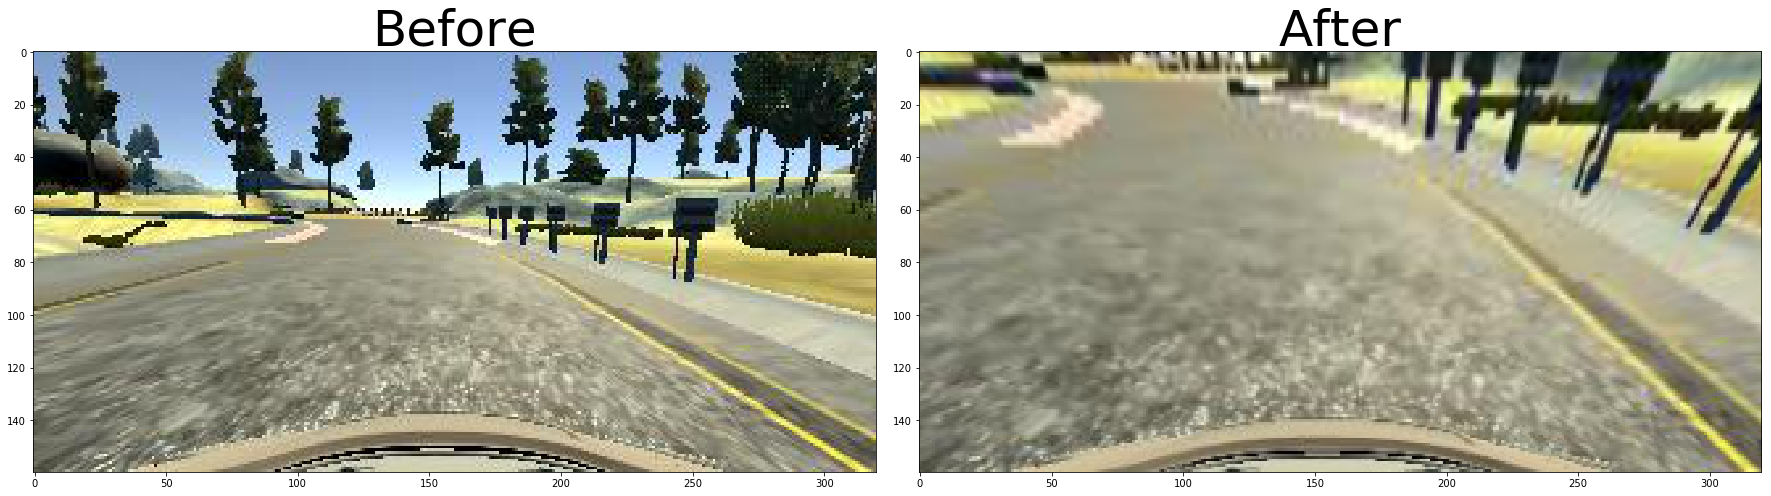

In [8]:
def side_by_side(img1, img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title('Before', fontsize=50)
    if len(img2.shape) == 2:
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2)
    ax2.set_title('After', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

img=plt.imread("/home/zhenyaf/data/nd/3/IMG/center_2018_10_09_02_15_51_635.jpg")
img2 = warp_perspective(img)
side_by_side(img, img2)

In [ ]:

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(h, w, c), output_shape=(h, w, c)))

model.add(Conv2D(12, (5, 5), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(18, (5, 5), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(36, (3, 3), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(48, (3, 3), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(150))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(80))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.summary()

# model.load_weights("w1/model-01-0.00425447.h5")

model.compile(loss='mse', optimizer='adam')


filepath="model-{epoch:02d}-{val_loss:.8f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_object = model.fit_generator(train_generator, steps_per_epoch= len(train_samples),
                    validation_data=validation_generator, validation_steps=len(validation_samples),
                    epochs=10, verbose = 1, workers=12,
                    shuffle=True, callbacks=[checkpoint])

print(history_object.history.keys())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 78, 158, 12)       912       
_________________________________________________________________
batch_normalization_9 (Batch (None, 78, 158, 12)       48        
_________________________________________________________________
activation_9 (Activation)    (None, 78, 158, 12)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 78, 158, 12)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 77, 18)        5418      
_________________________________________________________________
batch_normalization_10 (Batc (None, 37, 77, 18)        72        
__________

In [ ]:
# visualization
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()